In [1]:
pip install silence_tensorflow

  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.1-py3-none-any.whl size=4464 sha256=2d71cbd8b65cd22386b3a1032178e9e5e9131359eec01aa893c4e8651c9cf5af
  Stored in directory: /root/.cache/pip/wheels/7d/2c/24/e130d6102c0df56631b9db7479d9a6a53c5d97fb06b5f61b98
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=39e0dc00f5c3f89520854f7eab149408014d2cd52082360ad75efdd2e8e5ec4b
  Stored in directory: /root/.cache/pip/wheels/b6/72/c8/3054a5897ba0713dfa7a941364d68cbd42b0755c8e2ec1c18c
Successfully built silence_tensorflow support_developer
Note: you may need to restart the kernel to use updated packages.


In [2]:
# A function to avoid tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [3]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

## <a id='step21'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 2.1 | <b></span><span style="color:#368F8B"><b>Import Data</b></span></span>

In [5]:
base_dir = '/kaggle/input/fruit-and-vegetable-image-recognition'

In [6]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## <a id='step22'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 2.2 | <b></span><span style="color:#368F8B"><b>Count data and classes</b></span></span>

In [7]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [8]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 36
number of classes in validation folder : 36
number of classes in test folder : 36


In [9]:
# work on train folder and count number of samples per each class

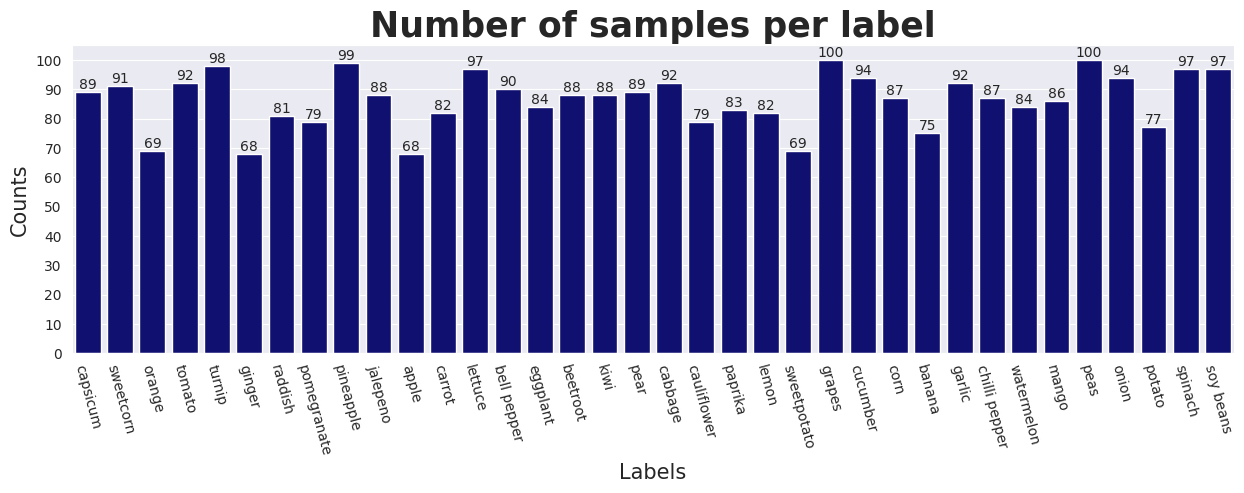

In [10]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

## <a id='step23'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 2.3 | <b></span><span style="color:#368F8B"><b>Convert data to a DataFrame</b></span></span>

In [11]:
# A function to return DataFrame

def create_df(folder_path) :
    all_images = []    
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [12]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [13]:
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 3115
Number of samples in validation : 351
Number of samples test : 359


# Show an image per each class(label)

## <a id='step24'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 2.4 | <b></span><span style="color:#368F8B"><b>Show an image per each class(label)</b></span></span>

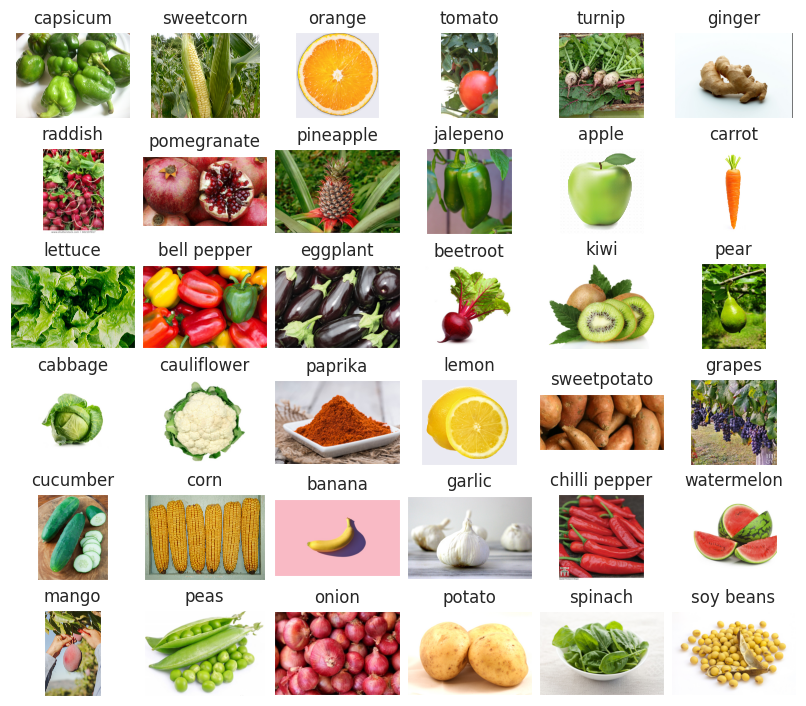

In [14]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

## <a id='step25'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 2.5 | <b></span><span style="color:#368F8B"><b>Data generators</b></span></span>

In [15]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,                  
    shuffle=True,
    seed=42,
    
)

Found 3115 validated image filenames belonging to 36 classes.


In [16]:
# validation generator

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 351 validated image filenames belonging to 36 classes.


In [17]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 359 validated image filenames belonging to 36 classes.


## <a id='step31'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.1 | <b></span><span style="color:#368F8B"><b>Add MobileNetV2 model</b></span></span>

In [18]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    pooling='avg'                         # type of pooling layer
)

9406464/9406464 [==============================] - 0s 0us/step


## <a id='step32'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.2 | <b></span><span style="color:#368F8B"><b>Freeze MobileNetV2 layers</b></span></span>

In [19]:
# Name of layers in MobileNetV2
for layer in pre_trained_model.layers :
    print(layer.name)

input_1
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand

In [20]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

## <a id='step33'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.3 | <b></span><span style="color:#368F8B"><b>Define a model</b></span></span>

In [21]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(36, activation='softmax'))

## <a id='step34'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.4 | <b></span><span style="color:#368F8B"><b>Model Diagram</b></span></span>

In [23]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 36)                4644      
                                                                 
Total params: 2623460 (10.01 MB)
Trainable params: 1251556 (4.77 MB)
Non-trainable params: 1371904 (5.23 MB)
_____________

## <a id='step35'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.5 | <b></span><span style="color:#368F8B"><b>Compile Model</b></span></span>

In [24]:
# Compile 
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy', 
             metrics=['accuracy'])

## <a id='step36'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.6 | <b></span><span style="color:#368F8B"><b>CallBacks</b></span></span>

In [25]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True) 

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

## <a id='step37'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.7 | <b></span><span style="color:#368F8B"><b>Train Model</b></span></span>

In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/100


I0000 00:00:1707236006.273924      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 [==============================] - 171s 2s/step - loss: 1.5782 - accuracy: 0.5560 - val_loss: 1.3124 - val_accuracy: 0.7236 - lr: 0.0010
Epoch 2/100
98/98 [==============================] - 121s 1s/step - loss: 0.7710 - accuracy: 0.7535 - val_loss: 1.0081 - val_accuracy: 0.7806 - lr: 0.0010
Epoch 3/100
98/98 [==============================] - 120s 1s/step - loss: 0.6174 - accuracy: 0.8045 - val_loss: 2.0180 - val_accuracy: 0.6638 - lr: 0.0010
Epoch 4/100
98/98 [==============================] - 120s 1s/step - loss: 0.4975 - accuracy: 0.8353 - val_loss: 1.6735 - val_accuracy: 0.7350 - lr: 0.0010
Epoch 5/100
98/98 [==============================] - 119s 1s/step - loss: 0.4605 - accuracy: 0.8462 - val_loss: 1.5709 - val_accuracy: 0.7664 - lr: 0.0010
Epoch 6/100
98/98 [==============================] - 121s 1s/step - loss: 0.3001 - accuracy: 0.8867 - val_loss: 0.6631 - val_accuracy: 0.8689 - lr: 5.0000e-04
Epoch 7/100
98/98 [==============================] - 124s 1s/step - loss: 0.20

## <a id='step38'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.8 | <b></span><span style="color:#368F8B"><b>Plot the result of training</b></span></span>

In [27]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

,loss,accuracy,val_loss,val_accuracy,lr
28,0.037871,0.987159,0.109736,0.974359,0.000063
29,0.033129,0.987159,0.109784,0.977208,0.000031
30,0.028631,0.988764,0.108027,0.977208,0.000031
31,0.027482,0.991011,0.106140,0.974359,0.000031
32,0.031940,0.988443,0.107242,0.974359,0.000016


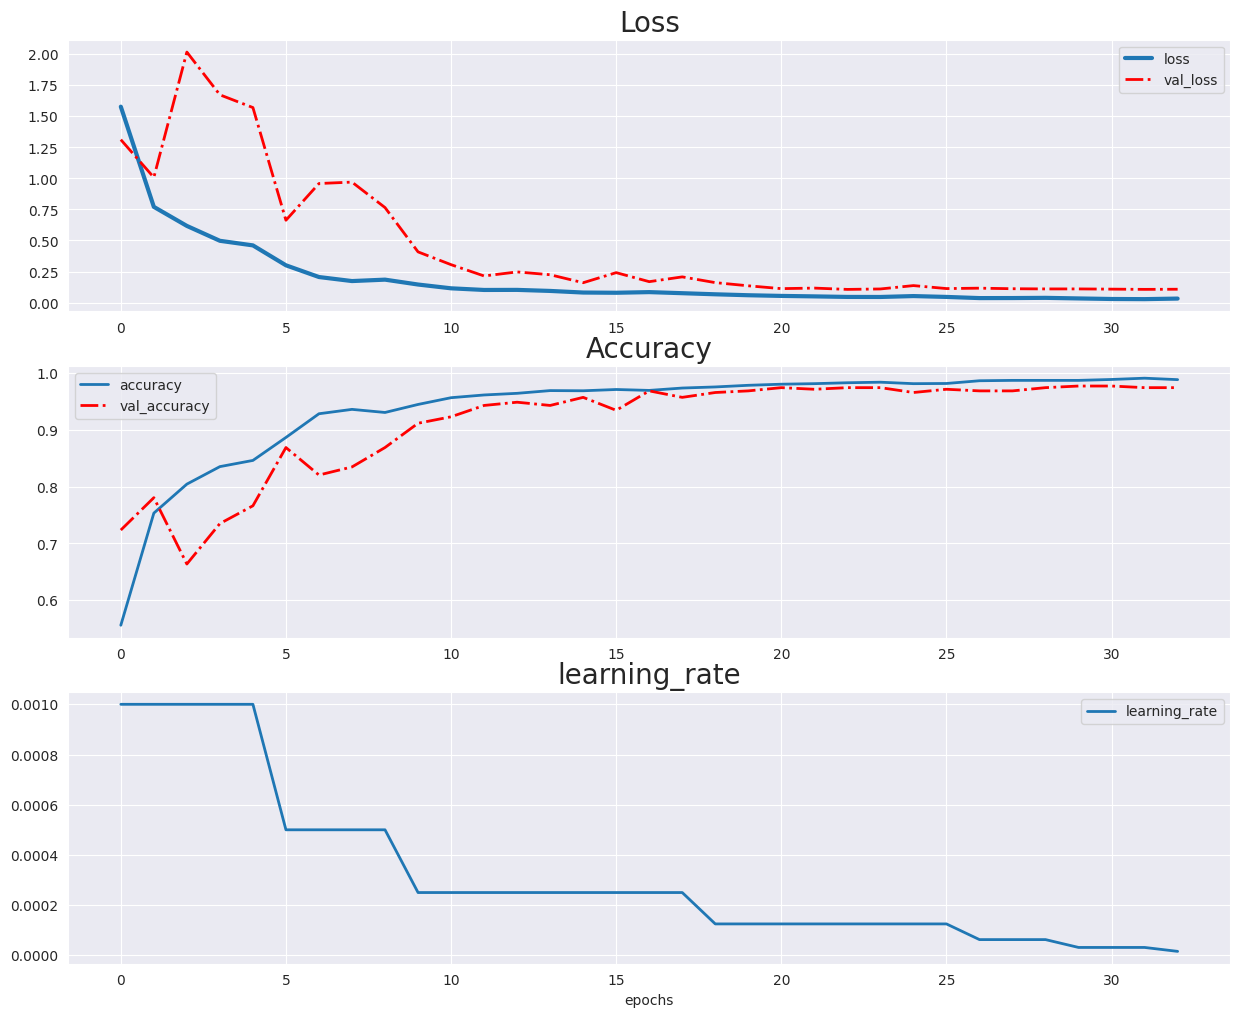

In [28]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.lr, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

## <a id='step39'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.9 | <b></span><span style="color:#368F8B"><b>Evaluate the Model</b></span></span>

In [29]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it
best_model = models.load_model('MyModel.keras')

In [30]:
test_loss, test_acc = best_model.evaluate_generator(test_generator)

print(colored(f'Test Loss : {round(test_loss, 3)}', 'green', attrs=['bold']))
print(colored(f'Test Accuracy : {round(test_acc, 3)}', 'green', attrs=['bold']))

Test Loss : 0.103
Test Accuracy : 0.975


In [31]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "#102C42"]
    # cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

11/11 [==============================] - 12s 985ms/step
               precision    recall  f1-score   support

        apple       0.82      0.90      0.86        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.82      1.00      0.90         9
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.80      0.89        10
       carrot       1.00      1.00      1.00         9
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00         9
         corn       0.90      0.90      0.90        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       1.00      1.00      1.00         9
        

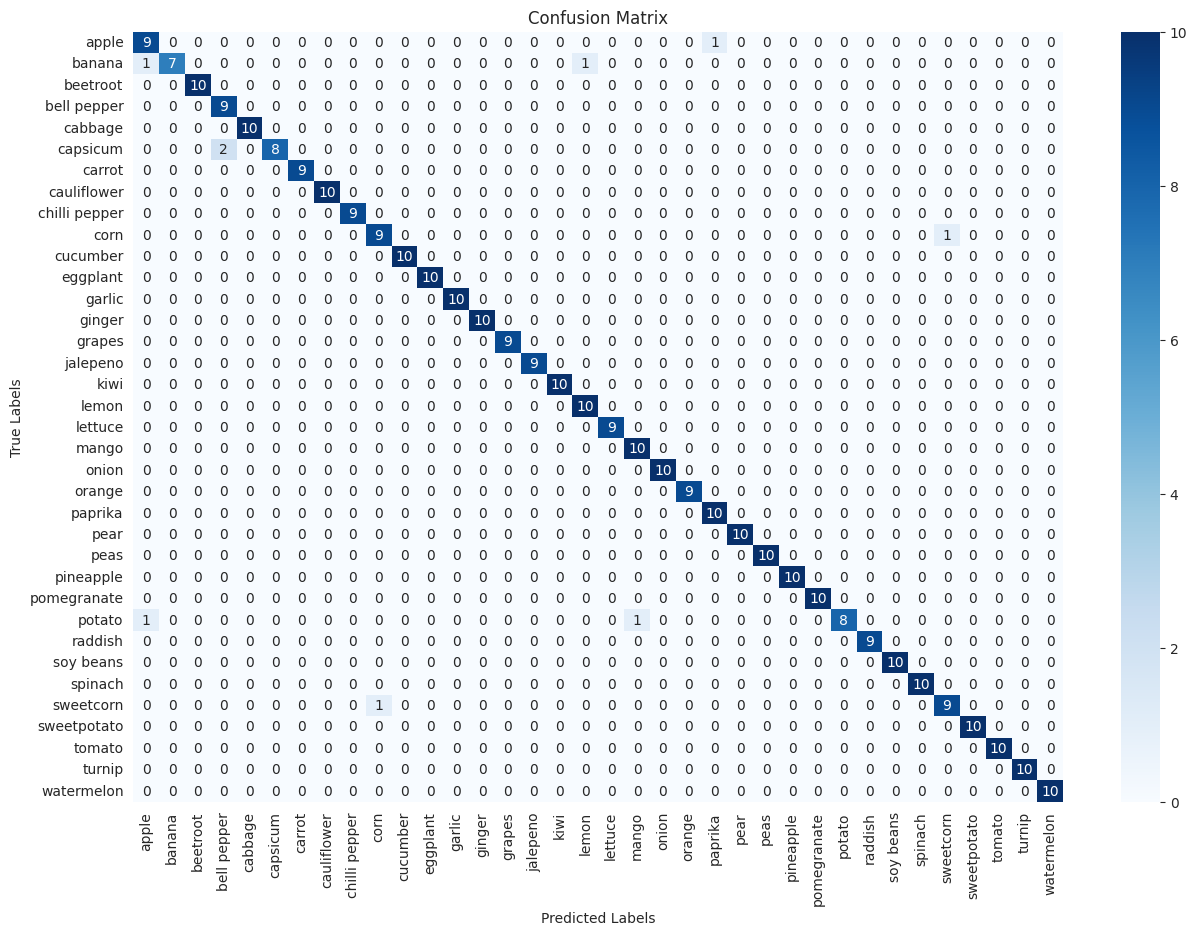

In [32]:
evaluate_model_performance(best_model, validation_generator, classes)

In [ ]:
model.save('MyModel.h5')

In [ ]:
end